## IMPORTING REQUIRED LIBRARIES

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import glob
import os
import shutil
import cv2
import random
import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential, model_from_json
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, GlobalAvgPool2D, Dropout , Flatten , AveragePooling2D , LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import load_img , img_to_array , ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report , confusion_matrix , accuracy_score , precision_recall_fscore_support
from tensorflow.keras.applications import inception_v3 

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow_addons as tfa

## DATA PREPARATION

In [ ]:
!wget https://www.dropbox.com/s/63dng0z88jmeoap/archive.zip?dl=0

In [ ]:
!unzip archive.zip?dl=0

In [ ]:
# main directory in which the whole data is present
dataset_path = './COVID-19_Radiography_Dataset'

# we will be dealing with two classes of x-ray images
classes = os.listdir(dataset_path)[6::2]
classes

['COVID', 'Normal']

In [ ]:
class2label = {}

for i in range(len(classes)):
    class2label[classes[i]] = i
    
label2class = {v:k for k, v in class2label.items()}

print(class2label)
print('-------------------------')
print(label2class)

{'COVID': 0, 'Normal': 1}
-------------------------
{0: 'COVID', 1: 'Normal'}


In [ ]:
covid_path = os.path.join(dataset_path, classes[0], '*')
covid_data = glob.glob(covid_path)
print(f'Number of Covid Images: {len(covid_data)}' , )
print('------------------------------')

noncovid_path = os.path.join(dataset_path, classes[1] , '*')
noncovid_data = glob.glob(noncovid_path)
print(f'Number of Non-Covid Images: {len(noncovid_data)}')

Number of Covid Images: 3616
------------------------------
Number of Non-Covid Images: 10192


In [ ]:
classes = []
image_name = []
image_id = []
image_format = []
labels = []

for i in range(len(covid_data)):
    cls , img = covid_data[i].split('/')[-2:]
    img_id , img_format = img.split('-')[-1].split('.')
    classes.append(cls)
    image_name.append(img)
    image_id.append(img_id)
    image_format.append(img_format) 
    labels.append(class2label[cls])
    
for i in range(len(noncovid_data)):
    cls , img = noncovid_data[i].split('/')[-2:]
    img_id , img_format = img.split('-')[-1].split('.')
    classes.append(cls)
    image_name.append(img)
    image_id.append(img_id)
    image_format.append(img_format) 
    labels.append(class2label[cls])

In [ ]:
combine_data = covid_data+noncovid_data

In [ ]:
pd.set_option('display.max_colwidth' , 100)

In [ ]:
# organising data into a dataframe for easy handling of data transformations later on

data = pd.DataFrame(list(zip(image_id , image_name , image_format , classes , labels , combine_data)))
data.columns = ['image_id' , 'image_name' , 'format' , 'Class' , 'label' , 'image_path']
data.sample(10 , random_state = 2)

,image_id,image_name,format,Class,label,image_path
6745,685,Normal-685.png,png,Normal,1,./COVID-19_Radiography_Dataset/Normal/Normal-685.png
492,1568,COVID-1568.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-1568.png
3374,958,COVID-958.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-958.png
1351,1155,COVID-1155.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-1155.png
1717,3024,COVID-3024.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-3024.png
2547,950,COVID-950.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-950.png
2109,50,COVID-50.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-50.png
3876,3850,Normal-3850.png,png,Normal,1,./COVID-19_Radiography_Dataset/Normal/Normal-3850.png
11388,699,Normal-699.png,png,Normal,1,./COVID-19_Radiography_Dataset/Normal/Normal-699.png
7545,1496,Normal-1496.png,png,Normal,1,./COVID-19_Radiography_Dataset/Normal/Normal-1496.png


## EXPLORATORY DATA ANALYSIS

In [ ]:
data.shape

(13808, 6)

In [ ]:
data['Class'].value_counts()

Normal    10192
COVID      3616
Name: Class, dtype: int64

In [ ]:
# checking for null values

if data.isnull().sum().sum() == 0:
    print('No Null Values found in dataset')
else:
    print(f'{data.isnull().sum().sum()} null values found in dataset')

No Null Values found in dataset


In [ ]:
# checking for any duplicate values

if data.duplicated().sum() == 0:
    print('No Duplicate Values found in dataset')
else:
    print(f'{data.duplicated().sum()} Duplicate values found in dataset')

No Duplicate Values found in dataset


In [ ]:
data['Class'].value_counts().index.to_list()

['Normal', 'COVID']

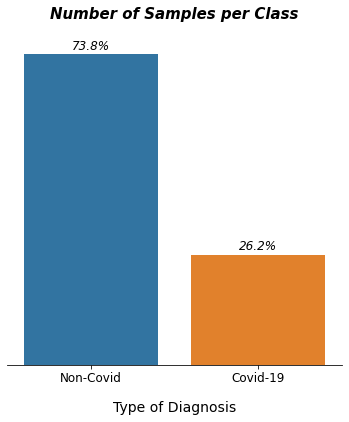

In [ ]:
# samples per class

plt.figure(figsize=(6, 6))

sns.countplot(data = data , x = 'Class' , order = data['Class'].value_counts().index )
sns.despine(top=True, right=True, left=True, bottom=False)

plt.xticks(ticks= [0,1], labels=['Non-Covid' , 'Covid-19'] , fontsize=12)
plt.yticks([])
plt.title('Number of Samples per Class' , fontsize=15 , pad=20 , fontstyle='italic' , fontweight = 800)
plt.xlabel('Type of Diagnosis' , fontsize=14 , fontweight=400, labelpad=16)
plt.ylabel('')
ax = plt.gca()

for p in ax.patches:
    ax.annotate("%.1f%%" % (100*float(p.get_height()/data.shape[0])), (p.get_x() + p.get_width() / 2., abs(p.get_height())) , ha='center', va='bottom', color='black', 
                xytext=(0,2),rotation = 'horizontal', textcoords='offset points' , fontsize = 12 , fontstyle = 'italic')

-  This is an Imbalanced dataset with nearly 74% of the dataset belonging to Non-Covid Samples. The model will probably perform better towards these samples.

- Due to imbalance nature of our data , accuracy can be misleading and hence it is much more reasonable to use metrics such as Precision, Recall and F1-Score
for evaluating model performance.

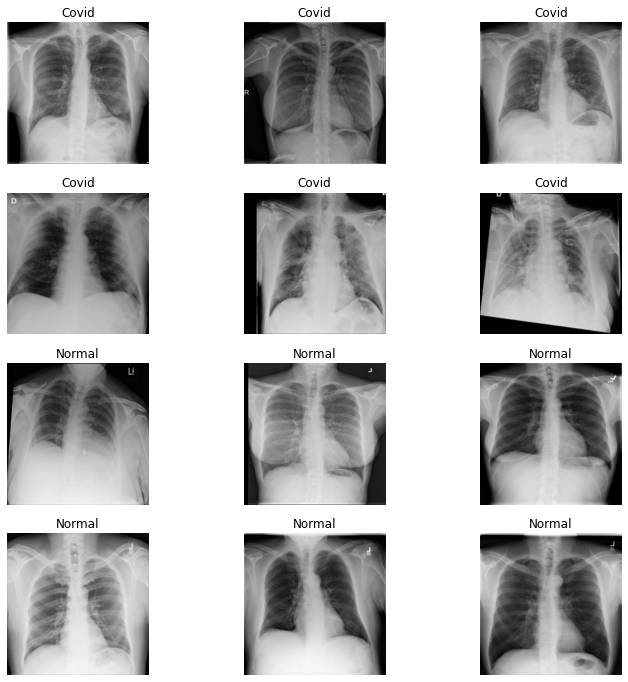

In [ ]:
# visualizing few image samples from each class
random.seed(0)
covid_imgs = random.sample(covid_data , 6)
non_covid_imgs = random.sample(noncovid_data , 6)
combine_sample_imgs = covid_imgs+non_covid_imgs

plt.figure(figsize = (12,12))
for i in range(12):
    plt.subplot(4 , 3 , i+1)
    img = cv2.imread(combine_sample_imgs[i])
    plt.title(combine_sample_imgs[i].split('/')[-2].capitalize() , fontsize = 12)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
# checking basic image parameters

print('Shape of the image : {}'.format(img.shape))

Shape of the image : (299, 299, 3)


In [ ]:
print('Image Height: {}'.format(img.shape[0]))
print('Image Width: {}'.format(img.shape[1]))
print('Image Dimensions/Channels: {}'.format(img.ndim))

Image Height: 299
Image Width: 299
Image Dimensions/Channels: 3


In [ ]:
print('Image size: {}'.format(img.size))
print('Image Data Type: {}'.format(img.dtype))

Image size: 268203
Image Data Type: uint8


In [ ]:
print('Maximum RGB value in this image {}'.format(img.max()))
print('Minimum RGB value in this image {}'.format(img.min()))

Maximum RGB value in this image 251
Minimum RGB value in this image 0


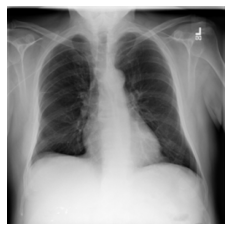

In [ ]:
# visualizing each individual channel of a sample image

random.seed(42)
path = random.sample(combine_sample_imgs , 1)
img = cv2.imread(path[0])
img = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()  

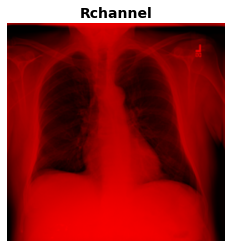

In [ ]:
r_channel = np.zeros(shape=img.shape, dtype=np.uint8)
r_channel[:,:,0] = img[:,:,0]

plt.title('Rchannel', fontsize=14, weight='bold')
plt.imshow(r_channel)
plt.axis('off');
plt.show()

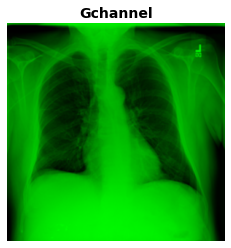

In [ ]:
g_channel = np.zeros(shape=img.shape, dtype=np.uint8)
g_channel[:,:,1] = img[:,:,1]

plt.title('Gchannel', fontsize=14, weight='bold')
plt.imshow(g_channel)
plt.axis('off');
plt.show()

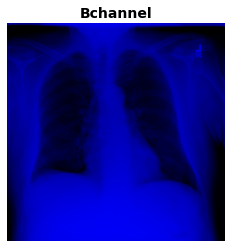

In [ ]:
b_channel = np.zeros(shape=img.shape, dtype=np.uint8)
b_channel[:,:,2] = img[:,:,2]

plt.title('Bchannel', fontsize=14, weight='bold')
plt.imshow(b_channel)
plt.axis('off');
plt.show()

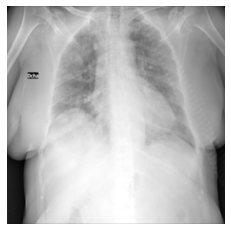

In [ ]:
# visualizing intensity distribution of an original low contrast image, its histpgram equalization and adaptive equalization for better contrast 

img = cv2.imread('COVID-19_Radiography_Dataset/COVID/COVID-52.png' , 0)
plt.imshow(img , cmap = 'gray')
plt.axis(False)
plt.show()

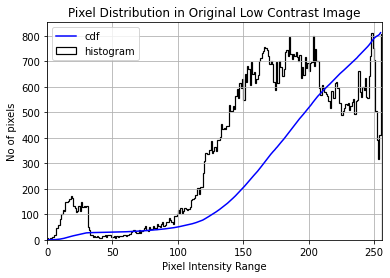

In [ ]:
hist , bins = np.histogram(img.flatten() , bins = 256 , range = [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf* float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'blue')
plt.hist(img.flatten(),256,[0,256], color = 'black', histtype = 'step' , linewidth = 1.2)
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.grid()
plt.title("Pixel Distribution in Original Low Contrast Image")
plt.xlabel("Pixel Intensity Range")
plt.ylabel("No of pixels")
plt.xlim((0, 256))
plt.show()

- Histogram Equalization - image processing technique used to improve contrast in images. 
- It accomplishes this by effectively spreading out the most frequent intensity values, i.e. stretching out the intensity range of the image. 
- This method usually increases the global contrast of images when its usable data is represented by close contrast values. 
- This allows for areas of lower local contrast to gain a higher contrast.

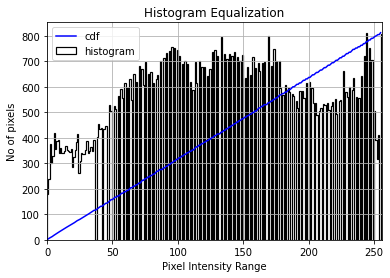

In [ ]:
eq = cv2.equalizeHist(img)

hist , bins = np.histogram(eq.flatten() , bins = 256 , range = [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf* float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'blue')
plt.hist(eq.flatten(),256,[0,256], color = 'black', histtype = 'step' , linewidth = 1.2)
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.grid()
plt.title("Histogram Equalization")
plt.xlabel("Pixel Intensity Range")
plt.ylabel("No of pixels")
plt.xlim((0, 256))
plt.show()

- Contrast Limited Adaptive Histogram Equalization (CLAHE) is another algorithm used to improve the contrast of images. 
- CLAHE , which takes care of over-amplification of the contrast , operates on small regions in the image, called tiles, rather than the entire image. The neighboring tiles are then combined using bilinear interpolation to remove the artificial boundaries.
- It is therefore suitable for improving the local contrast and enhancing the definitions of edges in each region of an image.


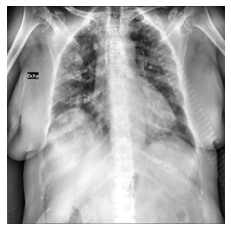

In [ ]:
clahe = cv2.createCLAHE(clipLimit = 3)
cl1 = clahe.apply(img)

plt.imshow(cl1 , cmap = 'gray')
plt.axis(False)
plt.show()

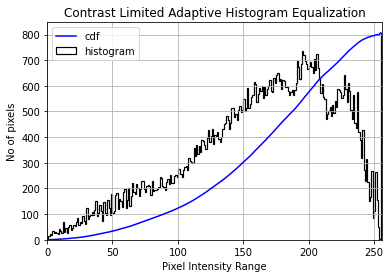

In [ ]:
hist , bins = np.histogram(cl1.flatten() , bins = 256 , range = [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf* float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'blue')
plt.hist(cl1.flatten(),256,[0,256], color = 'black', histtype = 'step' , linewidth = 1.2)
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.grid()
plt.title("Contrast Limited Adaptive Histogram Equalization")
plt.xlabel("Pixel Intensity Range")
plt.ylabel("No of pixels")
plt.xlim((0, 256))
plt.show()

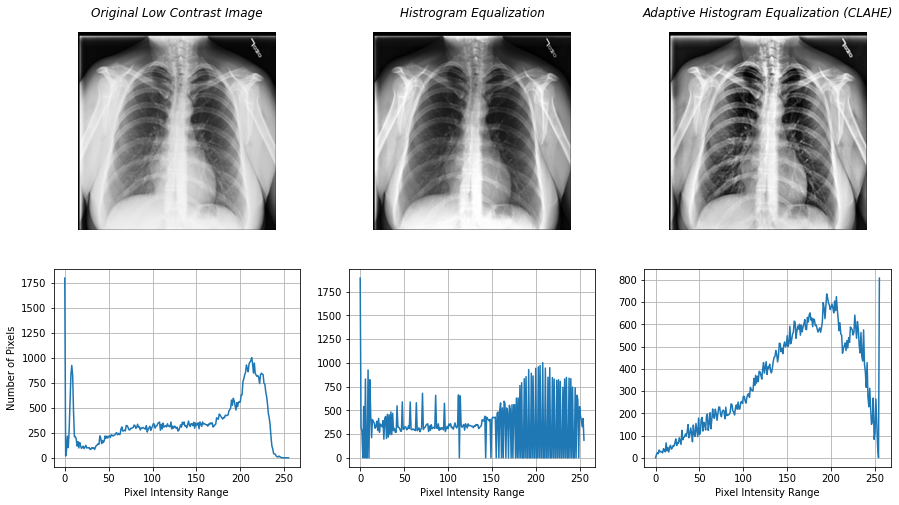

In [ ]:
img = cv2.imread('COVID-19_Radiography_Dataset/Normal/Normal-21.png' , 0)

fig , axis = plt.subplots(2,3 , figsize = (15 , 8))

hist1 = cv2.calcHist([img] , [0] , None , [256] , [0 , 256])  # images, channels, mask, histSize, ranges
axis[0,0].imshow(img, cmap=plt.cm.gray)
axis[0,0].axis('off')
axis[0,0].set_title('Original Low Contrast Image' , pad = 15 , fontstyle = 'italic')
axis[1,0].plot(hist1)
axis[1,0].grid(True)
axis[1,0].set_xlabel('Pixel Intensity Range')
axis[1,0].set_ylabel('Number of Pixels')

eq = cv2.equalizeHist(img)
hist2 = cv2.calcHist([eq] , [0] , None , [256] , [0 , 256])
axis[0,1].imshow(eq, cmap=plt.cm.gray)
axis[0,1].axis('off')
axis[1,1].plot(hist2)
axis[0,1].set_title('Histrogram Equalization' , pad = 15 , fontstyle = 'italic')
axis[1,1].grid(True)
axis[1,1].set_xlabel('Pixel Intensity Range')
#axis[1,1].set_ylabel('Number of Pixels')

clahe = cv2.createCLAHE(clipLimit = 3)
cl = clahe.apply(img)
hist3 = cv2.calcHist([cl1] , [0] , None , [256] , [0 , 256])
axis[0,2].imshow(cl, cmap=plt.cm.gray)
axis[0,2].axis('off')
axis[1,2].plot(hist3)
axis[0,2].set_title('Adaptive Histogram Equalization (CLAHE)' , pad = 15 , fontstyle = 'italic')
axis[1,2].grid(True)
axis[1,2].set_xlabel('Pixel Intensity Range')
#axis[1,2].set_ylabel('Number of Pixels')

plt.show()

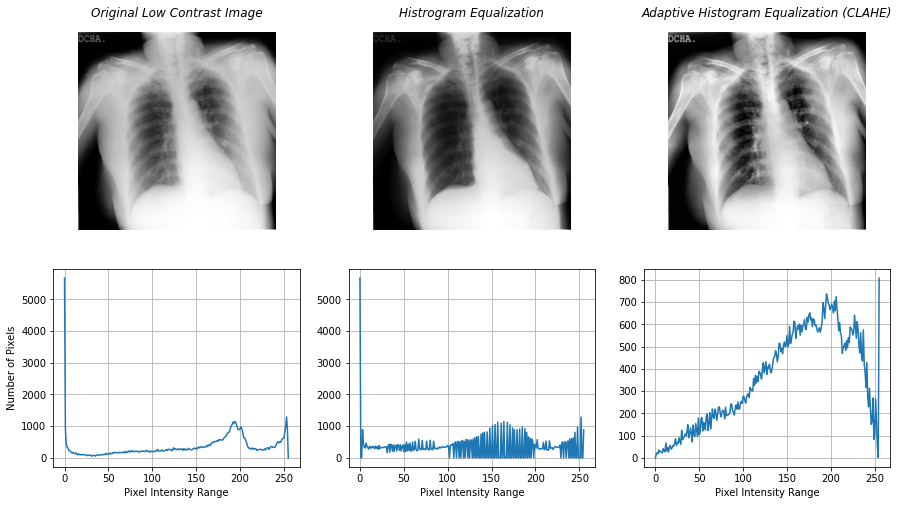

In [ ]:
img = cv2.imread('COVID-19_Radiography_Dataset/COVID/COVID-21.png' , 0)

fig , axis = plt.subplots(2,3 , figsize = (15 , 8))

hist1 = cv2.calcHist([img] , [0] , None , [256] , [0 , 256])  # images, channels, mask, histSize, ranges
axis[0,0].imshow(img, cmap=plt.cm.gray)
axis[0,0].axis('off')
axis[0,0].set_title('Original Low Contrast Image' , pad = 15 , fontstyle = 'italic')
axis[1,0].plot(hist1)
axis[1,0].grid(True)
axis[1,0].set_xlabel('Pixel Intensity Range')
axis[1,0].set_ylabel('Number of Pixels')

eq = cv2.equalizeHist(img)
hist2 = cv2.calcHist([eq] , [0] , None , [256] , [0 , 256])
axis[0,1].imshow(eq, cmap=plt.cm.gray)
axis[0,1].axis('off')
axis[1,1].plot(hist2)
axis[0,1].set_title('Histrogram Equalization' , pad = 15 , fontstyle = 'italic')
axis[1,1].grid(True)
axis[1,1].set_xlabel('Pixel Intensity Range')
#axis[1,1].set_ylabel('Number of Pixels')

clahe = cv2.createCLAHE(clipLimit = 3)
cl = clahe.apply(img)
hist3 = cv2.calcHist([cl1] , [0] , None , [256] , [0 , 256])
axis[0,2].imshow(cl, cmap=plt.cm.gray)
axis[0,2].axis('off')
axis[1,2].plot(hist3)
axis[0,2].set_title('Adaptive Histogram Equalization (CLAHE)' , pad = 15 , fontstyle = 'italic')
axis[1,2].grid(True)
axis[1,2].set_xlabel('Pixel Intensity Range')
#axis[1,2].set_ylabel('Number of Pixels')

plt.show()

In [ ]:
# create dataframe for examining any kind off pattern or relationships between the image colour values and their respective classes

mean_val = []
std_val = []
max_val = []
min_val = []

for i in range(data.shape[0]):
    img_arr = img_to_array(load_img(data['image_path'][i]))
    mean_val.append(img_arr.mean())
    std_val.append(img_arr.std())
    max_val.append(img_arr.max())
    min_val.append(img_arr.min())

data['mean_pixel'] = mean_val
data['std_dev'] = std_val
data['max_pixel'] = max_val
data['min_pixel'] = min_val

In [ ]:
data['mean_variation'] = data['mean_pixel'].mean() - data['mean_pixel']
data.sample(10 , random_state = 3)

,image_id,image_name,format,Class,label,image_path,mean_pixel,std_dev,max_pixel,min_pixel,mean_variation
6745,373,Normal-373.png,png,Normal,1,./COVID-19_Radiography_Dataset/Normal/Normal-3...,110.992035,67.981667,255.0,0.0,21.050950
492,244,COVID-244.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-244...,157.242981,37.429653,234.0,0.0,-25.199996
3374,3135,COVID-3135.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-313...,96.441475,45.486111,228.0,0.0,35.601510
1351,413,COVID-413.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-413...,160.184418,73.992592,254.0,0.0,-28.141433
1717,1382,COVID-1382.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-138...,160.415771,30.897856,239.0,59.0,-28.372786
2547,2645,COVID-2645.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-264...,159.280518,57.888550,255.0,0.0,-27.237533
2109,358,COVID-358.png,png,COVID,0,./COVID-19_Radiography_Dataset/COVID/COVID-358...,156.854233,44.923695,218.0,0.0,-24.811248
3876,6446,Normal-6446.png,png,Normal,1,./COVID-19_Radiography_Dataset/Normal/Normal-6...,138.758545,55.246765,249.0,0.0,-6.715560
11388,4189,Normal-4189.png,png,Normal,1,./COVID-19_Radiography_Dataset/Normal/Normal-4...,118.818329,67.291725,243.0,0.0,13.224656
7545,8844,Normal-8844.png,png,Normal,1,./COVID-19_Radiography_Dataset/Normal/Normal-8...,87.470024,71.229225,245.0,0.0,44.572961


#### Different types of plot illustrating how the mean, standard deviation, max and min colour values are presented for the dataset in each class

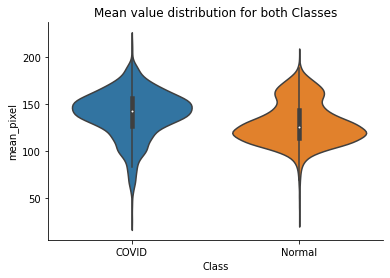

In [ ]:
sns.violinplot(y = 'mean_pixel' , data = data , x = 'Class')
sns.despine()
plt.title('Mean value distribution for both Classes')
plt.show()

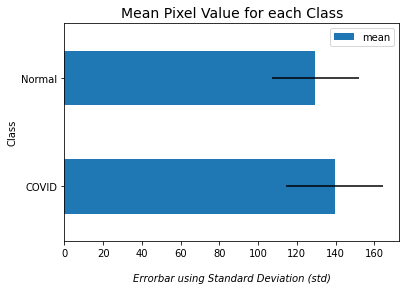

In [ ]:
df = data[['Class' , 'mean_pixel']].groupby("Class").agg([np.mean , np.std])
df.columns = df.columns.droplevel()
df.head()

df.plot(kind = "barh", y = "mean", xerr = "std" , legend = True)
plt.title("Mean Pixel Value for each Class" , fontsize = 14 , fontweight = 540)
plt.xlabel('Errorbar using Standard Deviation (std)' , labelpad =15 , fontstyle = 'italic')
plt.show()

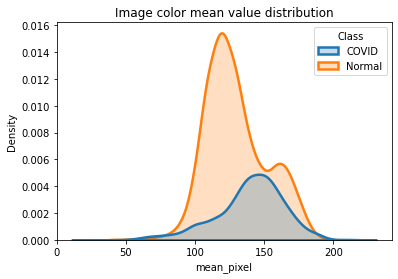

In [ ]:
sns.kdeplot(data = data , x = 'mean_pixel' , hue = 'Class' , shade = True , linewidth = 2.5)
plt.title('Image color mean value distribution')
plt.show()

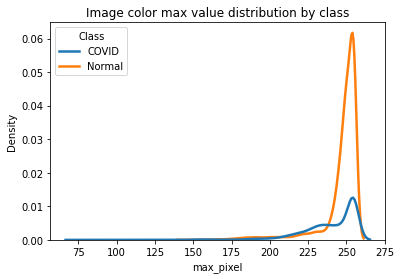

In [ ]:
sns.kdeplot(data = data , x = 'max_pixel', hue='Class' , linewidth = 2.5)
plt.title('Image color max value distribution by class')
plt.show()

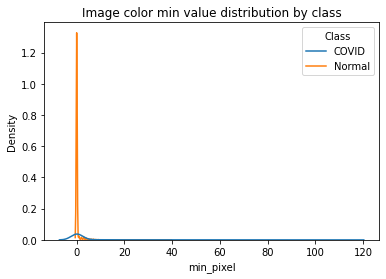

In [ ]:
sns.kdeplot(data = data , x = 'min_pixel', hue='Class')
plt.title('Image color min value distribution by class');

- We can visualise that the Mean, Max and Min values vary according to the image class.

- From mean value distribution plots , it can be concluded that for covid samples, the pixel density is maxium in the range 145-155 and the curve is slightly towards the right while for normal samples, the density is maximum around 125-130.

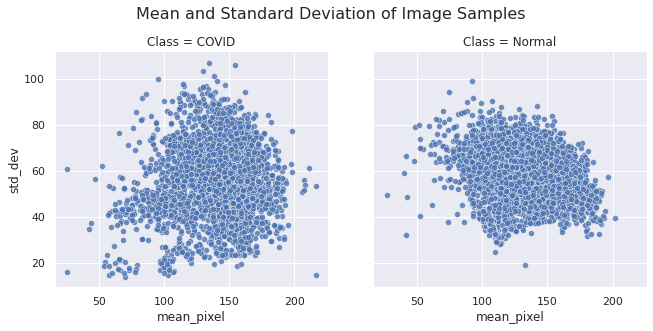

In [ ]:
# analysing the relationship between an image mean value and its standard deviation for both the classes

sns.set(rc={'figure.figsize':(16,8)})
fig = sns.relplot(data=data, x="mean_pixel", y=data['std_dev'],alpha=0.8, kind='scatter',col='Class');
sns.despine(top=True, right=True, left=False, bottom=False)

plt.suptitle('Mean and Standard Deviation of Image Samples', fontsize = 16 , fontweight = 550)
fig.tight_layout(pad=3);

## TRAIN-TEST SPLIT

In [ ]:
# main folder
!mkdir ./CovidDataset

# Train data folders
!mkdir ./CovidDataset/TrainData
!mkdir ./CovidDataset/TrainData/Covid/
!mkdir ./CovidDataset/TrainData/Normal/

# Test/Validation data folders
!mkdir ./CovidDataset/TestData
!mkdir ./CovidDataset/TestData/Covid/
!mkdir ./CovidDataset/TestData/Normal/

In [ ]:
split = 0.8

for f in os.listdir(dataset_path)[6::2]:
    path = os.path.join(dataset_path , f)
    imgs = os.listdir(path)

    split_size = int(split*len(imgs))
    train_imgs = imgs[:split_size]
    test_imgs = imgs[split_size:]

    for img_f in train_imgs:
        src_path = os.path.join(path , img_f)
        dest_path = os.path.join('./CovidDataset/TrainData' , f.capitalize() , img_f)
        shutil.copy(src_path , dest_path)
    for img_f in test_imgs:
        src_path = os.path.join(path , img_f)
        dest_path = os.path.join('./CovidDataset/TestData' , f.capitalize() , img_f)
        shutil.copy(src_path , dest_path)

In [ ]:
print("Training Data")
for f in os.listdir('./CovidDataset/TrainData'):
    path = os.path.join('./CovidDataset/TrainData' , f)
    print(f+ " : "+str(len(os.listdir(path))))  

print("\nValidation Data") 
for f in os.listdir('./CovidDataset/TestData'):
    path = os.path.join('./CovidDataset/TestData' , f)
    print(f+ " "+str(len(os.listdir(path))))

Training Data
Covid : 2892
Normal : 8153

Validation Data
Covid 724
Normal 2039


## DATA AUGMENTATION

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15, width_shift_range=0.15, height_shift_range=0.15,
                                   vertical_flip=False, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(directory='./CovidDataset/TrainData', target_size=(299, 299), batch_size=32, shuffle=True,
                                                    class_mode='binary')

val_generator = test_datagen.flow_from_directory(directory='./CovidDataset/TestData', target_size=(299, 299), batch_size=32, shuffle=False, 
                                                  class_mode='binary')

Found 11045 images belonging to 2 classes.
Found 2763 images belonging to 2 classes.


In [ ]:
print('Number of batch iteraions on training data' , len(train_generator))
print('Number of batch iteraions on test data' , len(val_generator))

Number of batch iteraions on training data 346
Number of batch iteraions on test data 87


In [ ]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

## USING SEQUENTIAL MODEL (FROM SCRATCH)

In [ ]:
model1 = Sequential(name = 'model_from_scratch')

# stacking one convolutional layer one over another increases receptive field, non-linearity in network which helps represent more complex functions 
model1.add(Conv2D(32 , kernel_size = (3,3) , activation = leaky_relu , input_shape = (299,299,3)))
model1.add(Conv2D(64 , (3,3) , activation = leaky_relu))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64 , (3,3) , activation = leaky_relu))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(128 , (3,3) , activation = leaky_relu))
model1.add(MaxPool2D(pool_size=(2,2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(64,activation = leaky_relu))
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))

model1.summary()

Model: "model_from_scratch"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 297, 297, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 295, 295, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 147, 147, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 147, 147, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 145, 145, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 72, 64) 

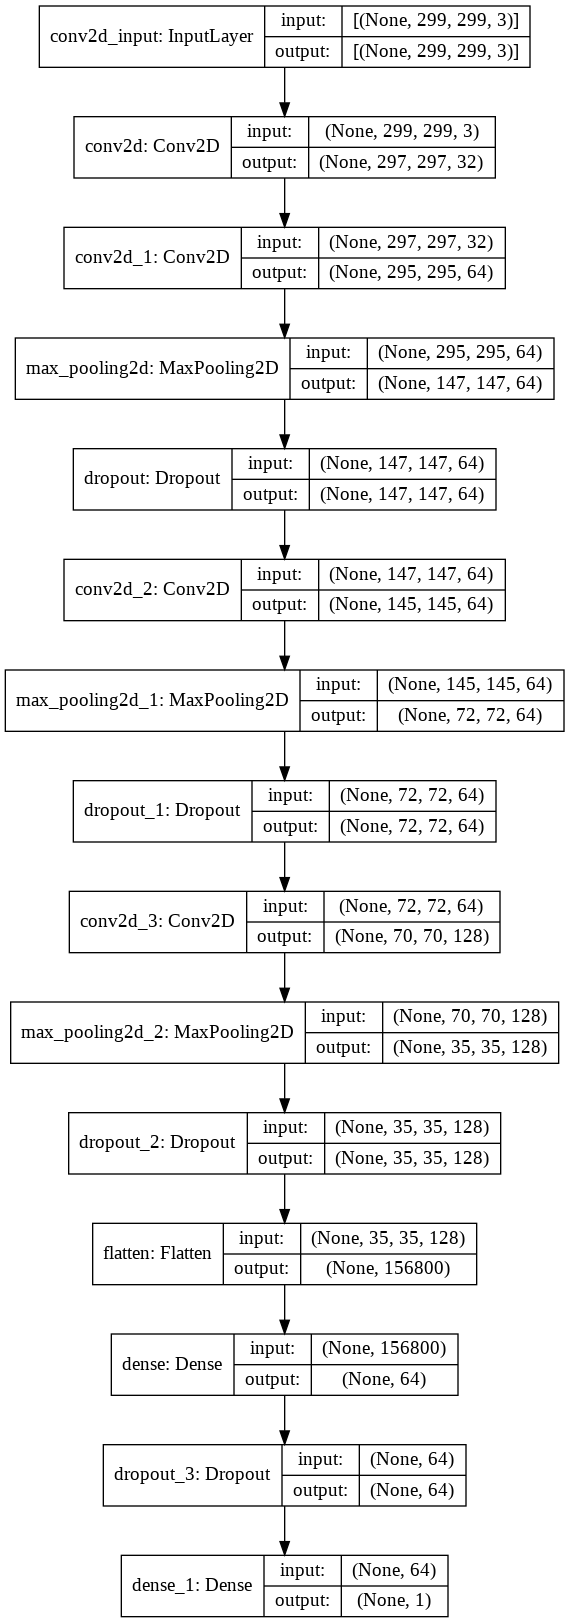

In [ ]:
plot_model(model1 , 'model1.png' , show_shapes=True)

In [ ]:
# Using leaky relu as activation function to avoid dead neuron condition
leaky_relu = LeakyReLU(alpha = 0.1)

# Stop training when a monitored metric has stopped improving to prevent overfitting 
early_stop = EarlyStopping(patience=5 , monitor='val_loss' , mode='min')

In [ ]:
model1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy' , Recall()])

In [ ]:
# model training
hist = model1.fit(train_generator, epochs=30, steps_per_epoch=len(train_generator), 
                 validation_data=val_generator, validation_steps=len(val_generator) , callbacks = [early_stop])

Epoch 1/30
346/346 [==============================] - 388s 1s/step - loss: 0.5685 - accuracy: 0.7454 - recall: 0.9669 - val_loss: 0.5236 - val_accuracy: 0.7481 - val_recall: 0.8588
Epoch 2/30
346/346 [==============================] - 351s 1s/step - loss: 0.5103 - accuracy: 0.7614 - recall: 0.9411 - val_loss: 0.4905 - val_accuracy: 0.7731 - val_recall: 0.9671
Epoch 3/30
346/346 [==============================] - 352s 1s/step - loss: 0.5007 - accuracy: 0.7672 - recall: 0.9371 - val_loss: 0.5290 - val_accuracy: 0.7267 - val_recall: 0.7783
Epoch 4/30
346/346 [==============================] - 354s 1s/step - loss: 0.4776 - accuracy: 0.7762 - recall: 0.9303 - val_loss: 0.4702 - val_accuracy: 0.7789 - val_recall: 0.8676
Epoch 5/30
346/346 [==============================] - 352s 1s/step - loss: 0.4694 - accuracy: 0.7788 - recall: 0.9211 - val_loss: 0.4534 - val_accuracy: 0.7991 - val_recall: 0.9514
Epoch 6/30
346/346 [==============================] - 360s 1s/step - loss: 0.4517 - accuracy: 0

## SAVING MODEL


In [ ]:
model1.save('model_1.h5')

In [ ]:
# serialize model to JSON
model_json = model1.to_json()
with open("model_1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model1.save_weights("model_1_weights.h5")
print("Saved model to disk")

Saved model to disk


## PREDICTIONS AND INFERENCE

In [ ]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])

In [ ]:
historyDF = pd.DataFrame(hist.history)
historyDF.head()

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
0,0.568486,0.745405,0.966883,0.523638,0.748100,0.858754
1,0.510328,0.761431,0.941126,0.490544,0.773073,0.967141
2,0.500712,0.767225,0.937078,0.528960,0.726746,0.778323
3,0.477567,0.776188,0.930332,0.470229,0.778864,0.867582
4,0.469450,0.778814,0.921133,0.453434,0.799131,0.951447


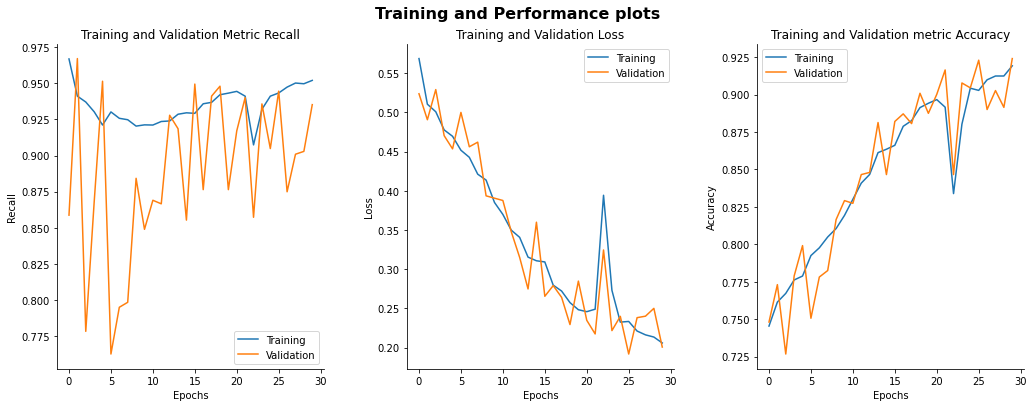

In [ ]:
# Plot accuracy , recall and losses for training and validation sets

fig, axarr = plt.subplots(1,3, figsize=(15,6), sharex=True)
sns.despine(top=True, right=True, left=False, bottom=False)

ax = sns.lineplot(x = historyDF.index, y = hist.history['recall'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history['val_recall'], ax=axarr[0], label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x = historyDF.index, y = hist.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')

ax = sns.lineplot(x = historyDF.index, y = hist.history['accuracy'], ax=axarr[2], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history['val_accuracy'], ax=axarr[2], label="Validation");
ax.set_ylabel('Accuracy')

axarr[0].set_title('Training and Validation Metric Recall')
axarr[1].set_title('Training and Validation Loss')
axarr[2].set_title('Training and Validation metric Accuracy')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Evaluating the model using various metrics 
loss , acc , recal = model1.evaluate(val_generator)
print('Loss on Test set:' , loss)
print('Test Accuracy:', round(acc*100 , 3))
print('Recall on test set', recal)

87/87 [==============================] - 63s 726ms/step - loss: 0.2112 - accuracy: 0.9139 - recall: 0.9250
Loss on Test set: 0.21115201711654663
Test Accuracy: 91.386
Recall on test set 0.9249632358551025


In [ ]:
y_pred = (model1.predict(val_generator)>0.5).astype('int')
y_pred.shape

(2763, 1)

In [ ]:
cm_plot_labels = list(val_generator.class_indices.keys())

In [ ]:
print(classification_report(val_generator.classes, y_pred , labels = [0,1] , target_names = cm_plot_labels))

              precision    recall  f1-score   support

       Covid       0.83      0.87      0.85       724
      Normal       0.95      0.94      0.95      2039

    accuracy                           0.92      2763
   macro avg       0.89      0.90      0.90      2763
weighted avg       0.92      0.92      0.92      2763



- The model's final accuracy is 92%.
- Covid-19 samples are more often misclassified as compared to Normal samples since the data is imbalanced. This is evident from the fact that f1-score for Normal class is 0.95 while it is only 0.85 for Covid class.


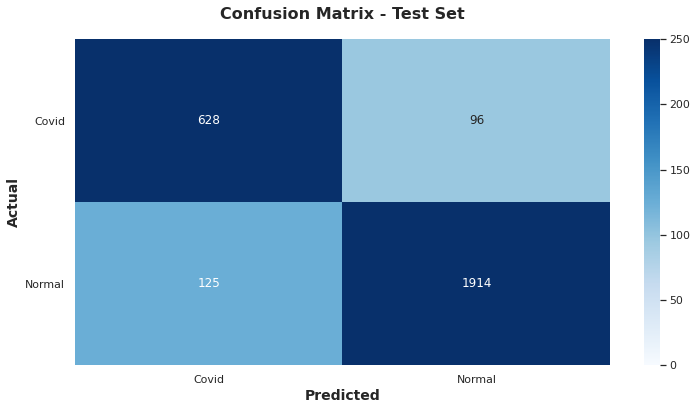

In [ ]:
# Plotting Confusion Matrix to visualize how well the model performs on each individual class

cm = confusion_matrix(val_generator.classes, y_pred)
cm = pd.DataFrame(cm, columns = cm_plot_labels, index = cm_plot_labels)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(cm, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

##  USING TRANSFER LEARNING FOR CLASSIFICATION
#### (InceptionV3 Model)

In [ ]:
# for train data
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.15, width_shift_range=0.15, height_shift_range=0.15,
                                   vertical_flip=False, horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(directory='./CovidDataset/TrainData', target_size=(224, 224), batch_size=32, shuffle=True)

# for test data
test_datagen = ImageDataGenerator(rescale = 1./255)

val_generator = test_datagen.flow_from_directory(directory='./CovidDataset/TestData', target_size=(224, 224), batch_size=32, shuffle=False)

Found 11045 images belonging to 2 classes.
Found 2763 images belonging to 2 classes.


In [ ]:
# Define the base model for Transfer Learning

base_model = inception_v3.InceptionV3(include_top = False, weights = 'imagenet', input_shape = (224, 224, 3))
base_model.output

<KerasTensor: shape=(None, 5, 5, 2048) dtype=float32 (created by layer 'mixed10')>

In [ ]:
x = AveragePooling2D(pool_size=(4, 4))(base_model.output)
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(2, activation="softmax")(x)
model2 = Model(inputs=base_model.input, outputs=output)

- Here we will not only replace and retrain the classifier on top of the ConvNet on the new dataset, but also fine-tune the weights of the pretrained network by continuing the backpropagation. 
- Keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset.

In [ ]:
len(model2.layers)

316

In [ ]:
for idx , layer in enumerate(model2.layers):
    print(idx , layer)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f4a3e760590>
1 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a311eb210>
2 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4a31e4f150>
3 <tensorflow.python.keras.layers.core.Activation object at 0x7f4a3d742890>
4 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a3d748390>
5 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4a3d74a090>
6 <tensorflow.python.keras.layers.core.Activation object at 0x7f4a3d751550>
7 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a3d7403d0>
8 <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f4a3d746610>
9 <tensorflow.python.keras.layers.core.Activation object at 0x7f4a3d753dd0>
10 <tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7f4a3d753610>
11 <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f4a3f35

In [ ]:
for layer in model2.layers[:290]:
    layer.trainable = False

In [ ]:
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 111, 111, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 111, 111, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 111, 111, 32) 0           batch_normalization_188[0][0]    
____________________________________________________________________________________________

In [ ]:
plot_model(model2 , 'inception_model.png' , show_shapes=True)

- Due to class imbalance, we will be using Focal Loss
- Focal Loss (FL) is an improved version of Cross-Entropy Loss that tries to handle the class imbalance problem by assigning more weights to hard or easily misclassified examples and to down-weight easy examples. So Focal Loss reduces the loss contribution from easy examples and increases the importance of correcting misclassified examples.

In [ ]:
model2.compile(optimizer = 'adam', loss = tfa.losses.SigmoidFocalCrossEntropy(), metrics = ['accuracy' , Recall()])

In [ ]:
# callbacks
early_stopping_monitor = EarlyStopping(patience=5, monitor='val_loss', mode='min')

callbacks_list = [learning_rate_reduction, early_stopping_monitor]

In [ ]:
hist = model2.fit(train_generator, epochs=25, steps_per_epoch=len(train_generator), 
                 validation_data=val_generator, validation_steps=len(val_generator) , callbacks = [early_stopping_monitor])

## SAVING THE MODEL

In [ ]:
model2.save('model_2.h5')
# serialize model to JSON
model_json = model2.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model2.save_weights("model_2_weights.h5")
print("Saved model to disk")

Saved model to disk


## EVALUATION AND PREDICTIONS

In [ ]:
historyDF = pd.DataFrame(hist.history)
historyDF.head()

,loss,accuracy,recall,val_loss,val_accuracy,val_recall
0,0.096878,0.862653,0.862653,0.066088,0.897213,0.897213
1,0.070122,0.898053,0.898053,0.064581,0.907709,0.907709
2,0.064553,0.905025,0.905025,0.061792,0.905537,0.905537
3,0.060136,0.912177,0.912177,0.054409,0.915671,0.915671
4,0.056050,0.916885,0.916885,0.056868,0.925805,0.925805


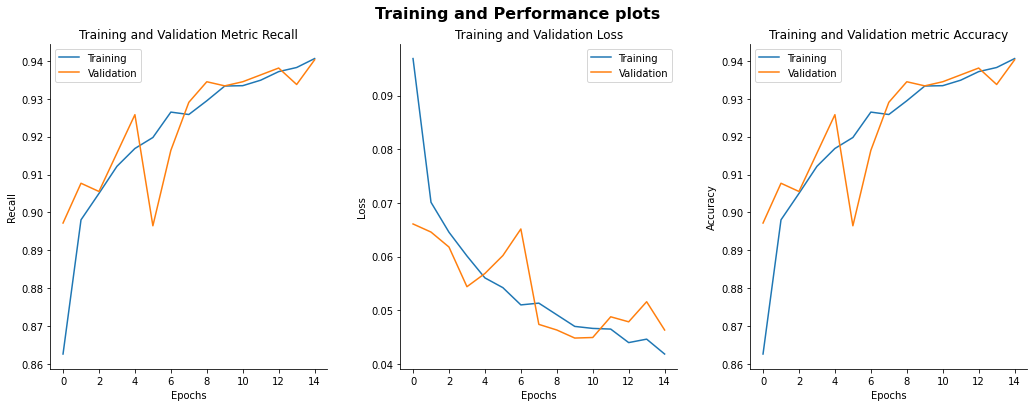

In [ ]:
# Plot accuracy , recall and losses for training and validation sets
fig, axarr = plt.subplots(1,3, figsize=(15,6), sharex=True)
sns.despine(top=True, right=True, left=False, bottom=False)

ax = sns.lineplot(x = historyDF.index, y = hist.history['recall'], ax=axarr[0], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history['val_recall'], ax=axarr[0], label="Validation");
ax.set_ylabel('Recall')

ax = sns.lineplot(x = historyDF.index, y = hist.history['loss'], ax=axarr[1], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history['val_loss'], ax=axarr[1], label="Validation");
ax.set_ylabel('Loss')

ax = sns.lineplot(x = historyDF.index, y = hist.history['accuracy'], ax=axarr[2], label="Training");
ax = sns.lineplot(x = historyDF.index, y = hist.history['val_accuracy'], ax=axarr[2], label="Validation");
ax.set_ylabel('Accuracy')

axarr[0].set_title('Training and Validation Metric Recall')
axarr[1].set_title('Training and Validation Loss')
axarr[2].set_title('Training and Validation metric Accuracy')

for ax in axarr:
    ax.set_xlabel('Epochs')

plt.suptitle('Training and Performance plots', fontsize=16, weight='bold');
fig.tight_layout(pad=3.0)
plt.show()

In [ ]:
# Evaluating the model
loss , acc , recal = model2.evaluate(val_generator)
print('Loss on Test set:' , loss)
print('Test Accuracy:', round(acc*100 , 3))
print('Recall on test set', recal)

87/87 [==============================] - 38s 432ms/step - loss: 0.0491 - accuracy: 0.9370 - recall: 0.9370
Loss on Test set: 0.04912536218762398
Test Accuracy: 93.702
Recall on test set 0.9370249509811401


In [ ]:
y_pred = model2.predict(val_generator).argmax(axis = 1)
y_pred.shape

(2763,)

In [ ]:
class2label = {v:k for k,v in val_generator.class_indices.items()}
class2label

{0: 'Covid', 1: 'Normal'}

In [ ]:
cm_plot_labels = list(val_generator.class_indices.keys())

In [ ]:
# Results based on different metrics

print(classification_report(val_generator.classes, y_pred , labels = [0,1] , target_names=cm_plot_labels))

              precision    recall  f1-score   support

       Covid       0.96      0.79      0.87       724
      Normal       0.93      0.99      0.96      2039

    accuracy                           0.94      2763
   macro avg       0.94      0.89      0.91      2763
weighted avg       0.94      0.94      0.93      2763



- Using transfer learning, we are able to achieve a bit higher accuracy than previous model i.e 94% accuracy
- Using pre-trained InceptionV3 Model and Focal Loss, precision and f1-score for class Covid has improved.
- While for Normal Class, recall and f1-score have improved 

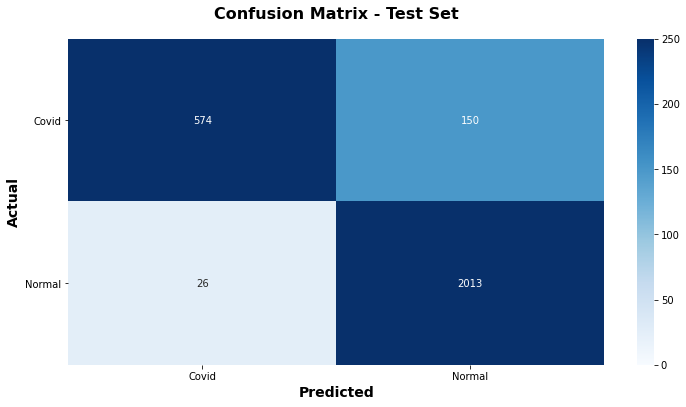

In [ ]:
cm = confusion_matrix(val_generator.classes, y_pred)
cm = pd.DataFrame(cm, columns=cm_plot_labels, index = cm_plot_labels)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(cm, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

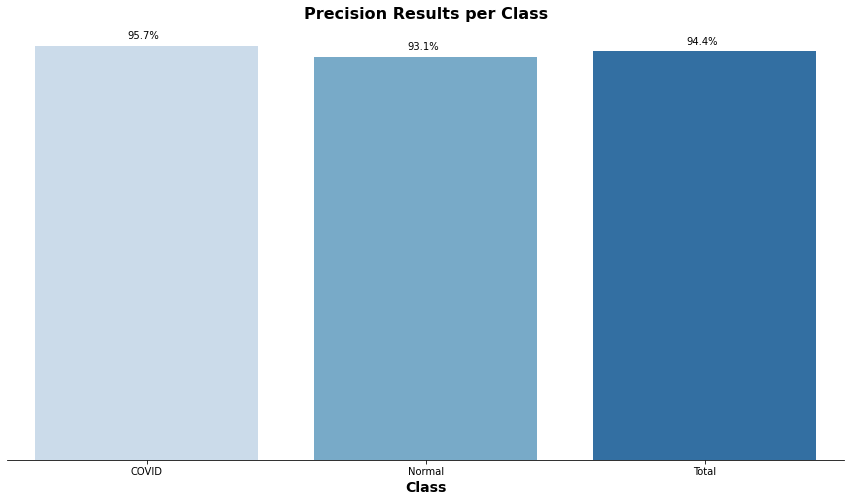

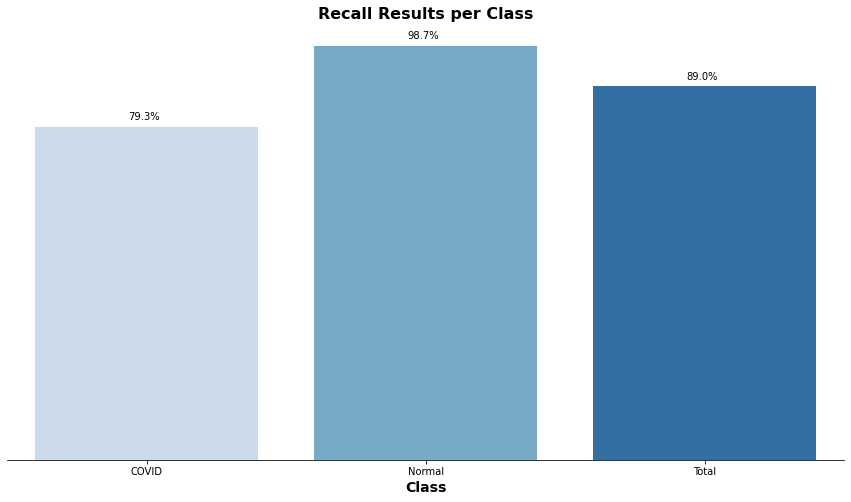

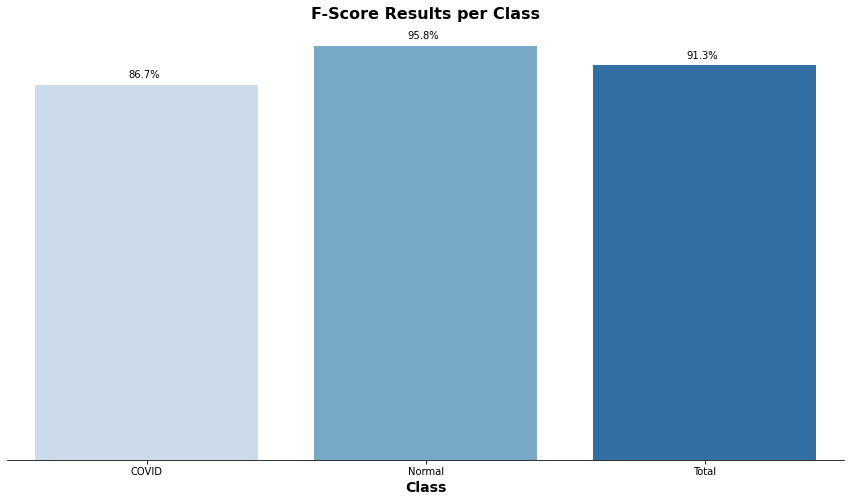

In [ ]:
acc = accuracy_score(val_generator.classes, y_pred)

results_all = precision_recall_fscore_support(val_generator.classes, y_pred , average='macro', zero_division=1)
results_class = precision_recall_fscore_support(val_generator.classes, y_pred , average=None, zero_division=1)

metric_columns = ['Precision','Recall', 'F-Score','S']
all_df = pd.concat([pd.DataFrame(list(results_class)).T,pd.DataFrame(list(results_all)).T])
all_df.columns = metric_columns
all_df.index = ['COVID' , 'Normal','Total']

def metrics_plot(df,metric):
    plt.figure(figsize=(15,8))
    ax = sns.barplot(data =df, x=df.index, y = metric,palette = 'Blues')
    #Bar Labels
    for p in ax.patches:
        ax.annotate("%.1f%%" % (100*p.get_height()), (p.get_x() + p.get_width() / 2., abs(p.get_height())),
        ha='center', va='bottom', color='black', xytext=(-3, 5),rotation = 'horizontal',textcoords='offset points')
    sns.despine(top=True, right=True, left=True, bottom=False)
    ax.set_xlabel('Class',fontsize = 14,weight = 'bold')
    ax.set_ylabel(metric,fontsize = 14,weight = 'bold')
    ax.set(yticklabels=[])
    ax.axes.get_yaxis().set_visible(False) 
    plt.title(metric+ ' Results per Class', fontsize = 16,weight = 'bold');

metrics_plot(all_df, 'Precision')
metrics_plot(all_df, 'Recall')
metrics_plot(all_df, 'F-Score')

## Grad-CAM Class Activation Visualization

In [ ]:
imgs , labels = next(iter(val_generator))

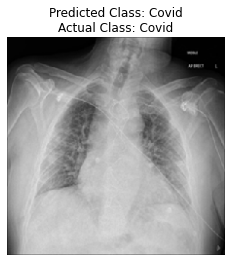

In [ ]:
predict = model2.predict(np.expand_dims(imgs[10], axis=0))
plt.imshow(imgs[10])
plt.axis(False)
pred_class = class2label[np.argmax(predict[0])]
target_class = class2label[labels[10].argmax()]
plt.title('Predicted Class: {}'.format(pred_class)+'\n'+'Actual Class: {}'.format(target_class))
plt.show()

In [ ]:
last_conv_layer_name = 'conv2d_93'

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):  
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

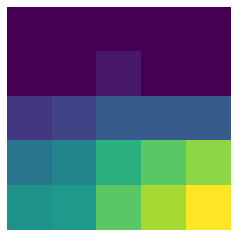

In [ ]:
# Prepare image
img_array = np.expand_dims(imgs[10] , axis=0)

# Remove last layer's softmax
model2.layers[-1].activation = None

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model2, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.axis(False)
plt.show()